# Experiment organization
Goal: Gather results from all topic modeling experiments using many stemming treatments for a particular corpus, then creates some visualizations.
The expected tree structure for the corpus and experiments is as follows:
```
<corpus> # corpus name - 'tiger','rnc' or 'opencorpora'
├── <corpus>_<stemmer> # stemmer or lemmatization treatment name, see topic_modeling/stemming.py for language details
│   ├── <corpus_oracleAnalysis.gz # Only present when stemmer=='oracle', the annotation labels for the words in the corpus, in sequence to match up with state files
│   ├── <corpus>_<stemmer>.mallet # mallet import-dir --output
│   ├── <corpus>_<stemmer>.tsv # output of topic_modeling/corpus_preprocessing.py for this particular treatment
│   ├── <corpus>_<stemmer>_<num_topics>_topics_<num_iters>_iters_<experiment_id> 
│   │   ├── <corpus>_<stemmer>_diagnostics.tsv # mallet train-topics metrics as tsv
│   │   ├── <corpus>_<stemmer>_diagnostics.xml # original mallet train-topics metrics format
│   │   ├── <corpus>_<stemmer>_doc_topics.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_entropy_metrics.tsv # metrics produced by by topic_modeling/mallet_parser slot-entropy
│   │   ├── <corpus>_<stemmer>.model # mallet topic model 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.tsv # mallet train-topics metrics for the version of this model lifted to lemmas 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.xml 
│   │   ├── <corpus>_<stemmer>_postLemmatized.mallet # mallet corpus sequence file lifted to lemmas (we probably only need to create this once, but I didn't think of that earlier, so for now each experiment gets its own)
│   │   ├── <corpus>_<stemmer>_postLemmatized.model # mallet topic model lifted to lemmas
│   │   ├── <corpus>_<stemmer>_postLemmatized_state.gz # mallet topic model state file lifted to 
│   │   ├── <corpus>_<stemmer>_state.gz # mallet topic model state file
│   │   ├── <corpus>_<stemmer>_top_docs.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_topic_keys.txt # mallet train-topics --output-topic-keys
│   │   ├── <corpus>_<stemmer>_topic_lemmas.tsv # Counts and conditional probablilities of lemmas for each topic
│   │   ├── <corpus>_<stemmer>_topic_pos.tsv  # Counts and conditional probablilities of parts-of-speech for each topic
│   │   ├── <corpus>_<stemmer>_topic_slots.tsv  # Counts and conditional probablilities of detailed morphological analyses for each topic
│   │   └── <corpus>_<stemmer>_top_terms.tsv # Raw counts of top 20 terms for each topic
└── voi_<num_topics>_topics # Variation of information between different models for the same number of topics
    └── <corpus>_<stemmer1>_<experiment1_id>_<corpus>_<stemmer2>_<experiment2_id>.tsv # Compares treatment 1 and treatment 2 

```



In [26]:
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="white")

In [27]:
def parse_experiment_directory(experiment_path):
    """Parses out all topic level metrics from a topic model's TSV results file, given the model's path. 
    Returns topic level metrics as a dataframe
    """
    dir_name = experiment_path.name
    split_name = dir_name.split("_")
    corpus = split_name[0]
    treatment = split_name[1]
    num_topics = split_name[2]
    experiment_id = split_name[-1]
    original_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_diagnostics.tsv", sep="\t", index_col="id", na_filter=False)

    final_frame = original_mallet_diagnostics
    final_frame['negative_coherence'] = - final_frame['coherence']

    final_frame.insert(loc = 0, column="corpus", value = corpus)
    final_frame.insert(loc = 1, column="stemmer", value=treatment)
    final_frame.insert(loc = 2, column="num_topics", value=int(num_topics))
    final_frame.insert(loc = 3, column="experiment_id", value = experiment_id)

    lemma_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_postLemmatized_diagnostics.tsv", sep="\t", index_col="id")
    lemma_mallet_diagnostics.rename(columns = {"exclusivity":"lemma_exclusivity"}, inplace=True)
    
    final_frame["lemma_exclusivity"] = lemma_mallet_diagnostics["lemma_exclusivity"]

    entropy_metrics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_entropy_metrics.tsv", sep = "\t", index_col="topic")

    final_frame = pd.merge(final_frame, entropy_metrics, left_index= True, right_index = True)
    final_frame = final_frame.reset_index().rename(columns={"id":"topic_id"})

    return final_frame

def parse_voi_tsv(voi_tsv):
    """Returns a dataframe for the VOI results in a single VOI tsv output.
    """
    split_name = voi_tsv.name[:-4].split("_")
    stemmer_a = split_name[1]
    a_exp_id = split_name[2]
    stemmer_b = split_name[4]
    b_exp_id = split_name[5]
    voi_frame = pd.read_csv(voi_tsv, sep="\t", index_col=False, names = ["a_path", "b_path", "voi"])
    voi_frame["stemmer_a"] = stemmer_a
    voi_frame["a_experiment_id"] = a_exp_id
    voi_frame["stemmer_b"] = stemmer_b
    voi_frame["b_experiment_id"] = b_exp_id
    if stemmer_a != stemmer_b:
        # VOI is symmetric, so flip them too
        flipped_df = voi_frame.copy()
        flipped_df["stemmer_a"] = stemmer_b
        flipped_df["a_experiment_id"] = b_exp_id
        flipped_df["stemmer_b"] = stemmer_a
        flipped_df["b_experiment_id"] = a_exp_id
        voi_frame = pd.concat([voi_frame, flipped_df], ignore_index=True)
    return voi_frame

def parse_voi_directory(voi_path):
    """Parses out all VOI comparisons between experiments from the TSVs in the VOI directory.
    Returns all VOI comparisons as a dataframe
    """
    tsvs = voi_path.glob("*.tsv")
    return pd.concat([parse_voi_tsv(t) for t in tsvs], ignore_index=True, sort=False)

# Corpus stats

In [28]:
corpus_name = "tiger"
corpus_root = Path("/home/virginia/workspace/topic-modeling-study") / corpus_name
experiment_folders = list(corpus_root.glob(f"{corpus_name}_*/*_topics_*_iters_*"))
voi_folders = list(corpus_root.glob("voi_*"))
corpus_stats_tsv = corpus_root / f"{corpus_name}_corpus_stats.tsv"
print("Num experiment folders found:", len(experiment_folders))
print("VOI folders:", voi_folders)

# How to order treatments in plots
hue_order = ["raw", "oracle", "spacy", "stanza", "snowball", "truncate6", "truncate5"]

Num experiment folders found: 140
VOI folders: [PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_100_topics'), PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_50_topics')]


,stemmer,token_count,word_type_count,type_to_token_ratio,char_to_token_ratio
0,raw,310925,76802,0.247011,8.92389
1,oracle,310925,56053,0.180278,8.50997
2,spacy,310925,62713,0.201698,8.61280
3,snowball,310925,53859,0.173222,7.61651
4,stanza,310925,38796,0.124776,7.57288
5,truncate5,310925,25753,0.082827,4.87998
6,truncate6,310925,35569,0.114397,5.70368


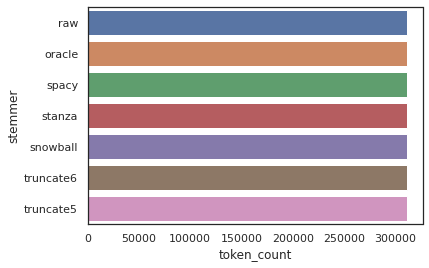

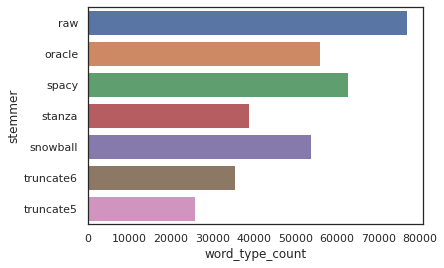

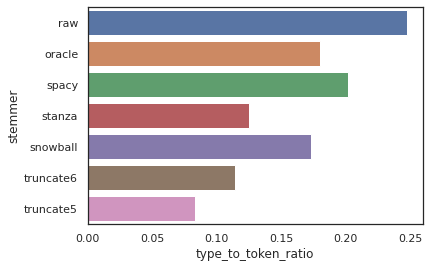

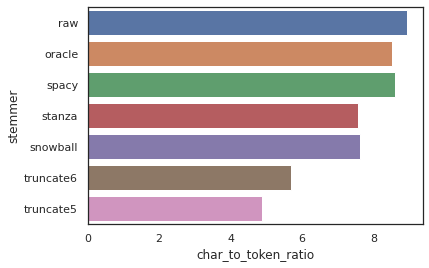

In [29]:
stat_cols = ['token_count', 'word_type_count', 'type_to_token_ratio', 'char_to_token_ratio']
stats_frame = pd.read_csv(corpus_stats_tsv, sep="\t", index_col=False)
display(stats_frame)

for i, c in enumerate(stat_cols):
    plt.figure(i)
    sns.barplot(data = stats_frame, x=c, y="stemmer", order=hue_order)

In [30]:
# Concat all experiment results together, save off results
full_frame = pd.concat([parse_experiment_directory(f) for f in experiment_folders], ignore_index=True, sort=False)
print("Total entries:", len(full_frame))
full_frame.to_csv(corpus_root / f'{corpus_name}_all_experiments_metrics.tsv', sep='\t', index=False)
full_frame.head(3)

Total entries: 10500


,topic_id,corpus,stemmer,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
0,0,tiger,snowball,50,8,2641.0,4.1690,6.8,-707.1285,4.1534,3.9693,380.4135,0.0170,0.1393,0.0000,0.0492,0.6355,707.1285,0.6607,9.786555,5.916711,2.116046,1.4,3.40,0.35,international singapur verdi asiat argentini brasilian dollar mexikan castellanos usa indonesi iwf hauptstadt mexiko brasili land indisch japan indi korall,international singapur verdi koralle dollar brasilianisch indonesien usa indien iwf asiatisch brasilien mexikanisch mexiko land indisch lateinamerika japan experte argentinien,indonesier international singapur verdi koralle dollar mexikaner brasilianisch indonesien castellanos usa indien iwf hauptstädter asiatisch brasilien castellano hauptstadt mexikanisch mexiko asiate land indisch japaner japan verdienen japanisch argentinien,lateinamerika experte,indonesier mexikaner hauptstädter japaner castellano hauptstadt verdienen japanisch castellanos asiate,28,2,10
1,1,tiger,snowball,50,8,2059.0,3.2936,8.7,-471.6296,4.4840,4.2848,239.5052,0.0216,0.2097,0.0513,0.1613,0.7168,471.6296,0.7442,9.358991,5.609732,1.772997,1.6,2.15,0.30,lehr elt informationsgesellschaft einfuhr bundesregier informat universitat wissenschaft ausbildungsforder student studiengebuhr studi studium bafog and anzeig rektor passau studier hochschul,einführung fiff informationsgesellschaft eltern studie beck universität bundesregierung ausbildungsförderung erichsen student anzeige hochschule bafög studium studiengebühr rektor studierend passau gebühr,passauer lehre einführung lehr informationsgesellschaft einfuhr studentisch eltern studieren studie universität bundesregierung wissenschaft ausbildungsförderung einführen lehrer student ändern anderer anzeige hochschule lehren wissenschaftlich informatiker bafög studium and studiengebühr rektor studierend passau informatik,beck erichsen fiff gebühr,passauer lehre lehr studieren lehrer and einführen einfuhr ändern informatiker wissenschaft anderer wissenschaftlich informatik lehren studentisch,32,4,16
2,2,tiger,snowball,50,8,20997.0,6.2136,6.9,-336.9139,4.0575,1.9951,494.2861,0.0016,0.0299,0.0012,0.0164,0.2903,336.9139,0.3209,10.152023,5.810889,2.571047,2.4,5.95,0.50,staat zahl neu arbeit europa beschaftigt gesellschaft staatlich usa deutschland unternehm erhalt offent entsprech zukunft zusatz einzeln wirtschaft konnt hoh,staat beispielsweise neu arbeit gesellschaft entsprechend künftig staatlich usa deutschland bestehen hoch erhalten können zukunft einzeln öffentlich zusätzlich unternehmen schaffen,zählen staat arbeitend erhältlich zahlen beschäftigter neue wirtschaftlichkeit europäer öffentlichkeit zahl höhe neu arbeit europa gesellschaft entsprechend wirtschaftlich staatlich zukünftig unternehmer usa zähler gesellschaftlich einzelner deutschland arbeiter gesellschafter beschäftigt unternehmung wirtschaften hoch erhalten beschäftigen können zukunft zusatz einzeln arbeiten neuerlich öffentlich europäisch zusätzlich unternehmen wirtschaft erhaltung erhalt entsprechen,bestehen beispielsweise künftig schaffen,zählen beschäftigter arbeitend erhältlich neue zahl wirtschaftlichkeit europäer öffentlichkeit höhe europa wirtschaftlich zukünftig unternehmer zähler gesellschaftlich einzelner arbeiter gesellschafter beschäftigt unternehmung wirtschaften beschäftigen erhalt zusatz arbeiten neuerlich europäisch erhaltung wirtschaft zahlen entsprechen,48,4,32


In [31]:
num_topics = [50, 100]
num_topics_splits = []
for t in num_topics:
    topic_df = full_frame[full_frame["num_topics"] == t]
    num_topics_splits.append((t, topic_df))

for t, df in num_topics_splits:
    print(t, "topics length:", len(df))



50 topics length: 3500
100 topics length: 7000


# Entropy metrics
Using the annotated corpus as the oracle for lemma, parts of speech and morphological analysis, what's the entropy of topics with respect the original to the grammatical forms of the original wordforms in the documents? 

The treated corpora should have lower lemma entropies, since lemmatiztion forces wordtypes with the same lemma to be together. We would also expect the treated corpora to have higher slot entropy than the raw corpus, because treatments conflate many wordforms with different morphological analyses, but this does not appear to be the case.

- 'raw' has most extreme mean in all cases of entropy metrics - low document entropy & high entropy for grammatical features
- 'raw' (no treatment) has higher lemma and morphological slot entropy than all other treatments. How can the untreated corpus get both higher average lemma entropy and higher average slot entropy? If our expectation is that all forms of a particular lemma concentrate in a given topic (low lemma entropy, high slot entropy), this finding runs counter to that expectation.

<Figure size 432x288 with 0 Axes>

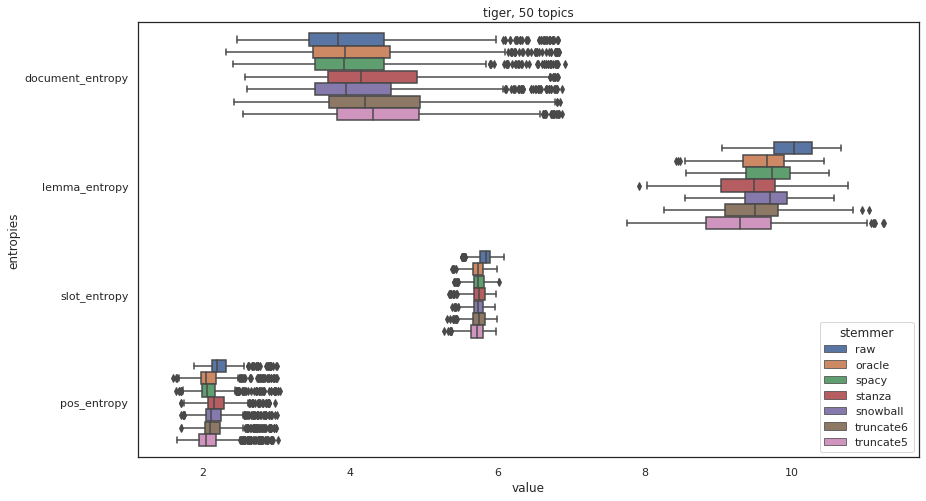

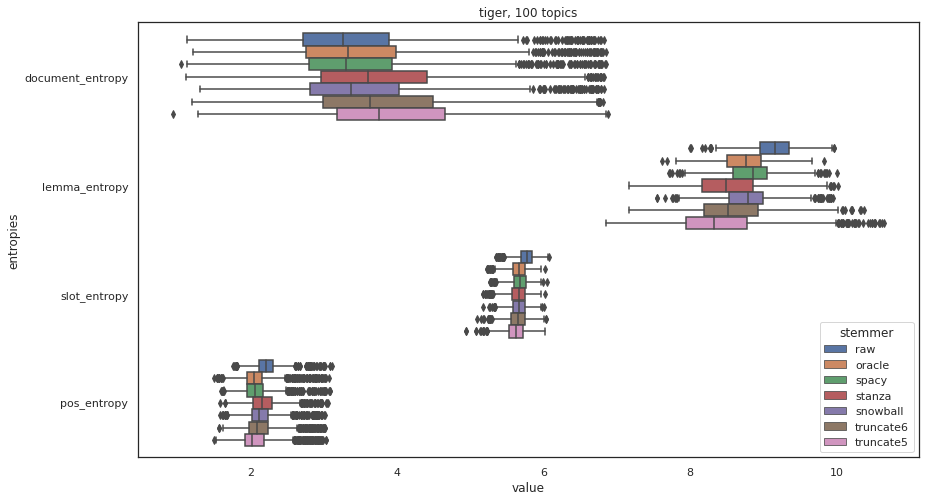

In [32]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    entropy_metrics = ['document_entropy', 'lemma_entropy', 'slot_entropy', 'pos_entropy']
    entropy_stats = pd.melt(df, "stemmer", var_name="entropies", value_vars=entropy_metrics)
    plt.figure(i)
    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="stemmer", data = entropy_stats, hue_order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

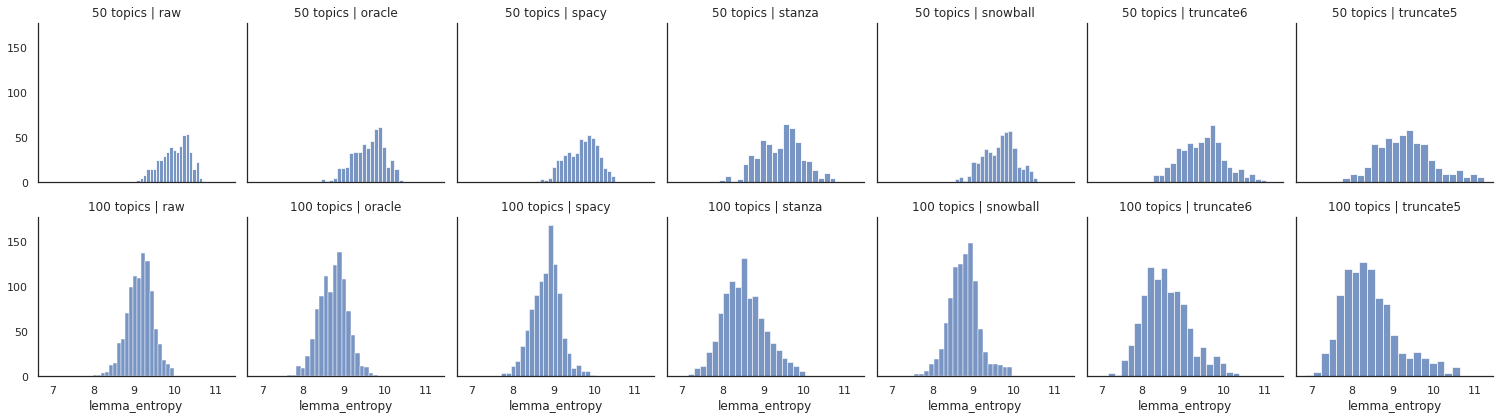

In [33]:
g = sns.FacetGrid(full_frame, col="stemmer", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "lemma_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

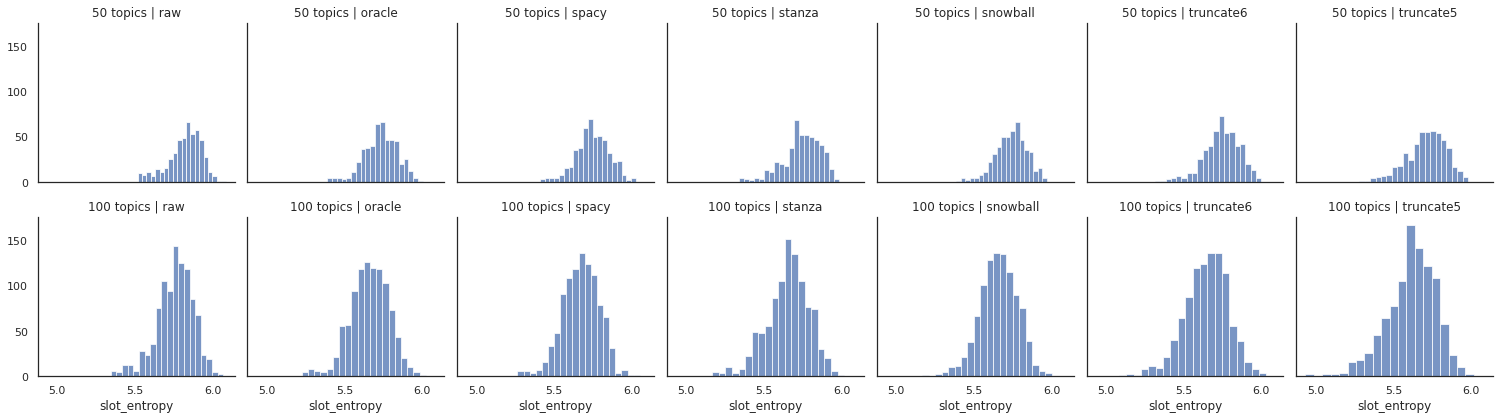

In [34]:
g = sns.FacetGrid(full_frame, col="stemmer", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "slot_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

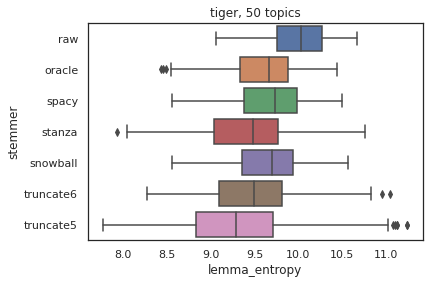

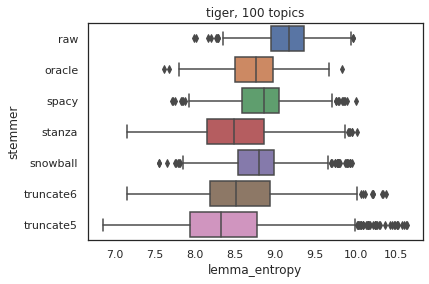

In [35]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemma_entropy', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

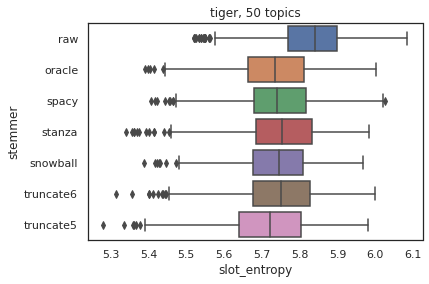

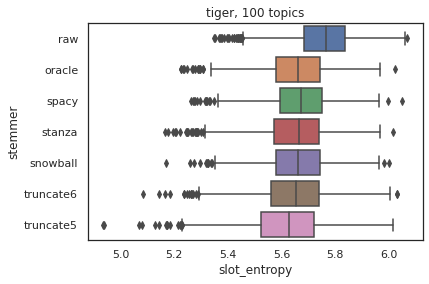

In [36]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slot_entropy', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

<Figure size 432x288 with 0 Axes>

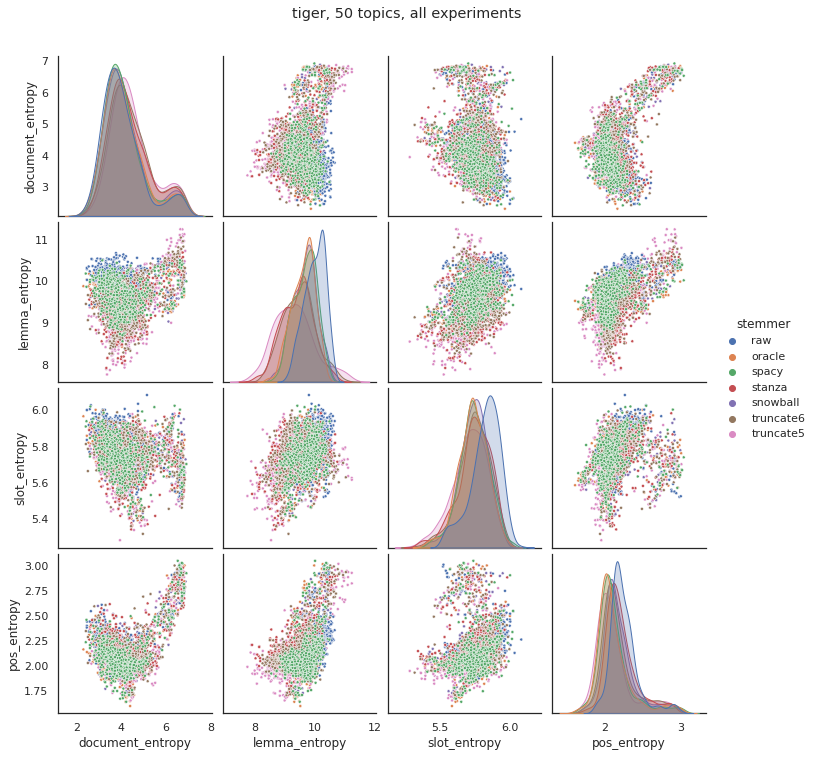

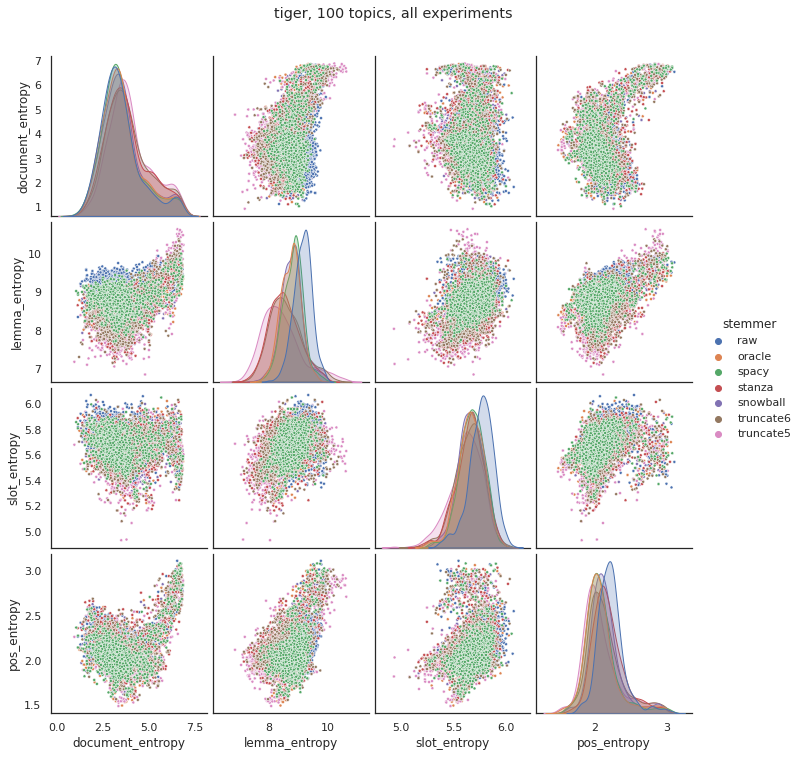

In [37]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    g = sns.pairplot(df, hue="stemmer", vars=entropy_metrics, markers='.', hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name}, {num_topics} topics, all experiments", y = 1.05)

<Figure size 432x288 with 0 Axes>

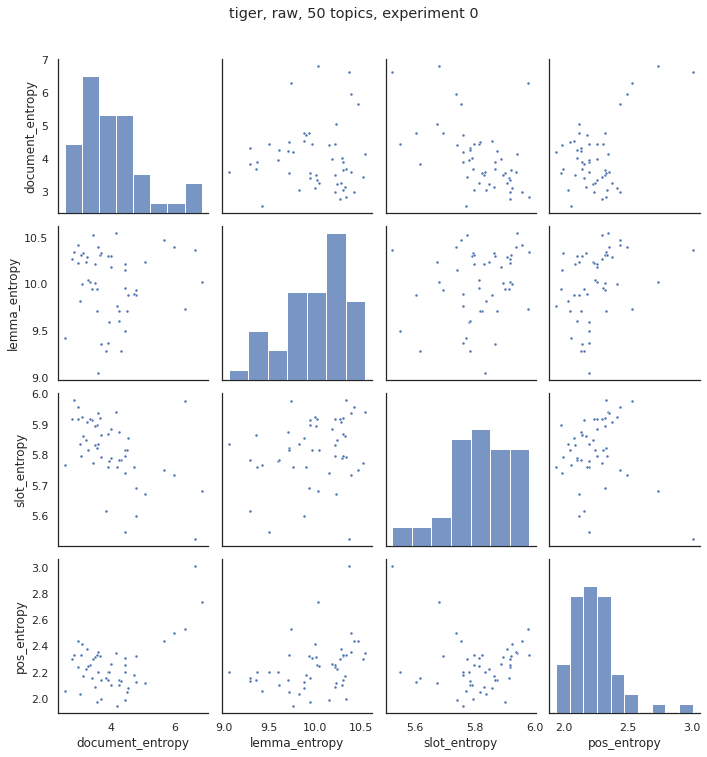

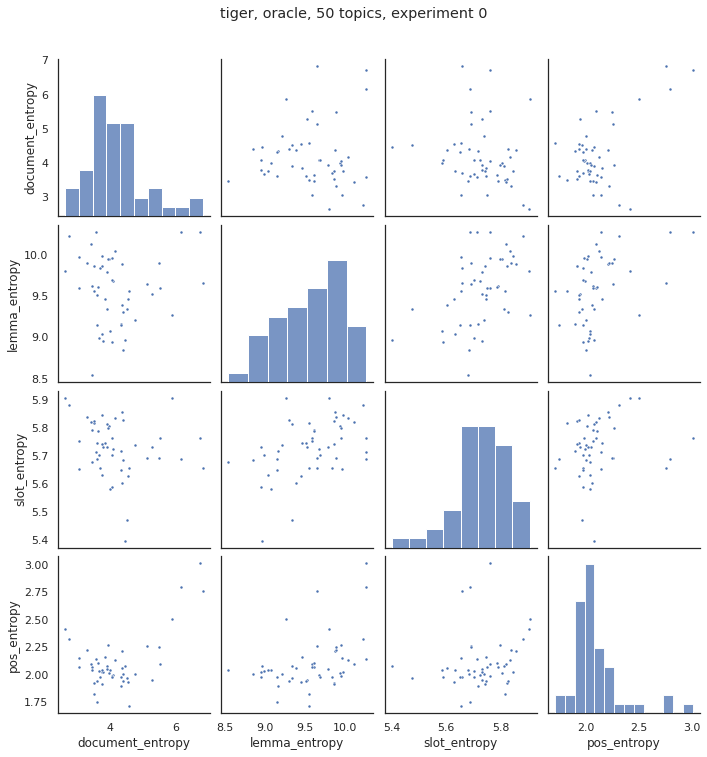

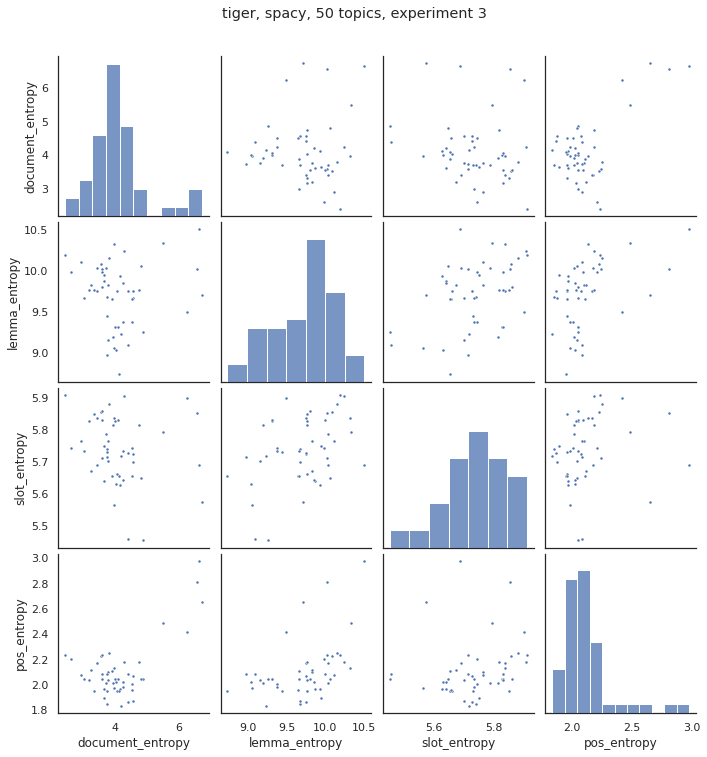

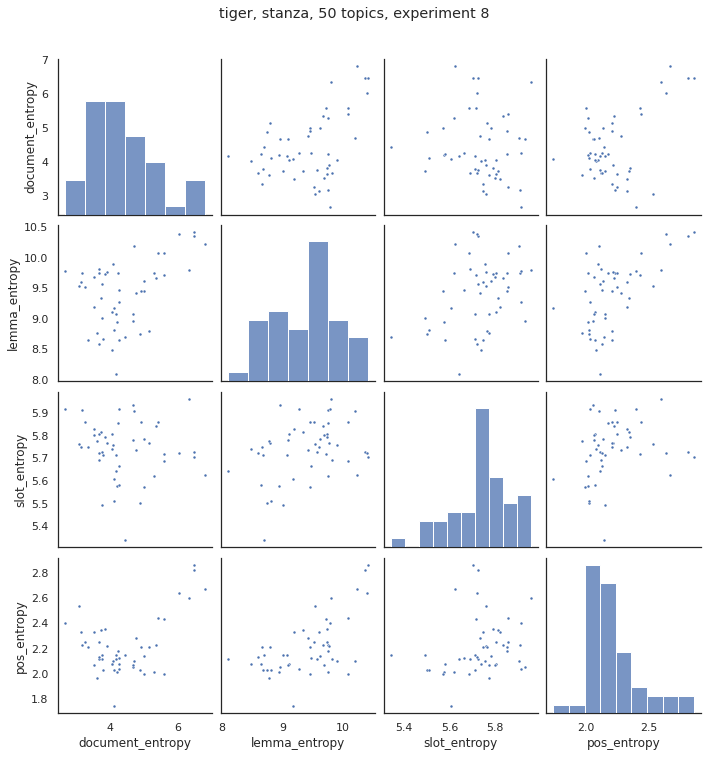

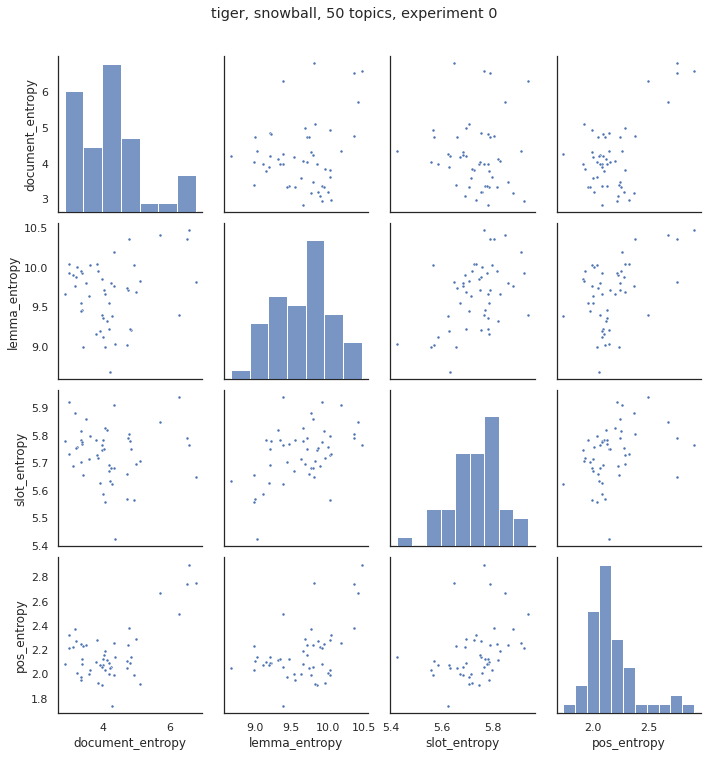

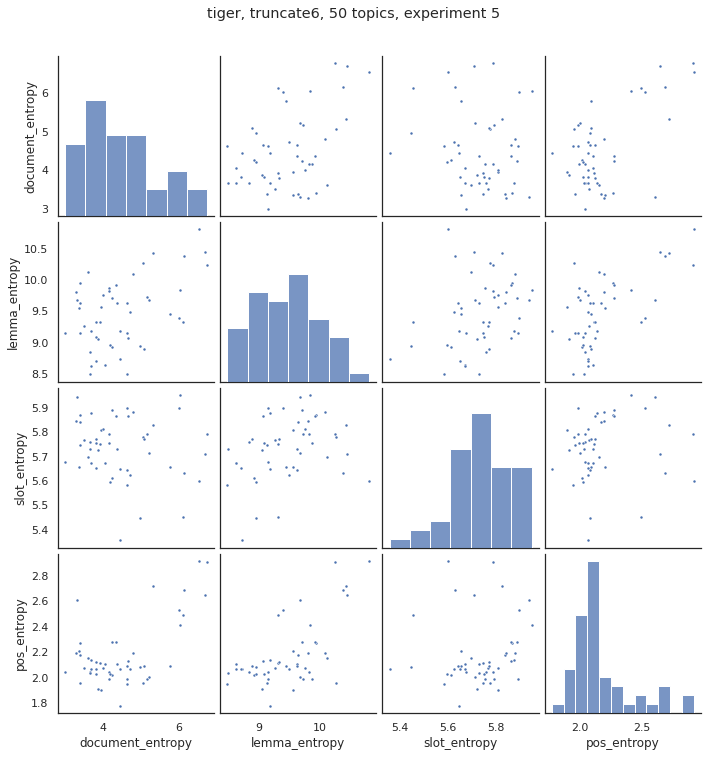

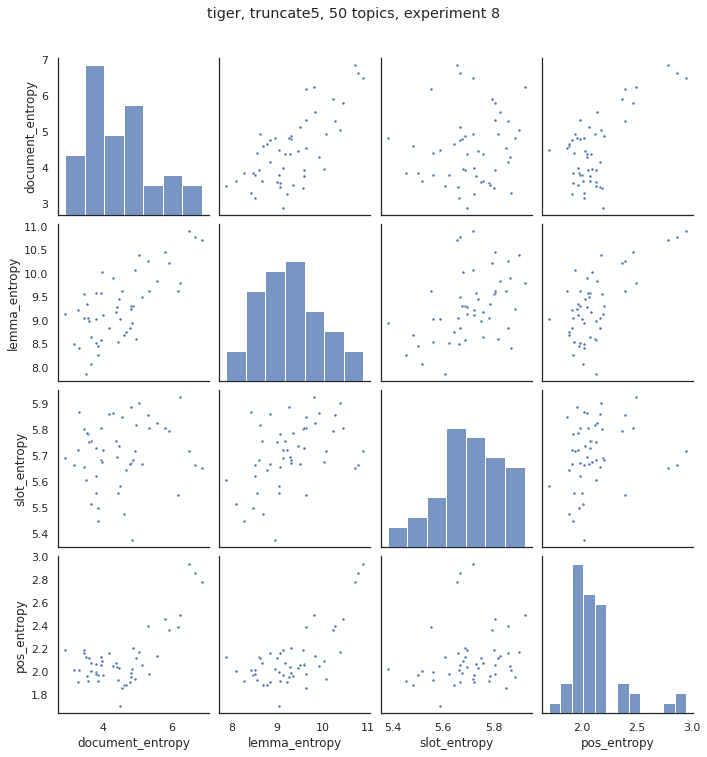

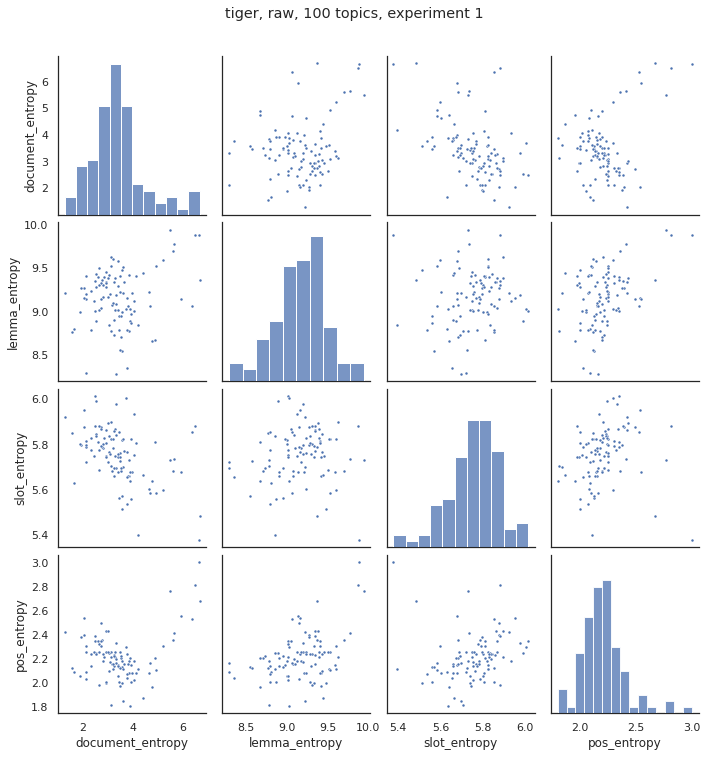

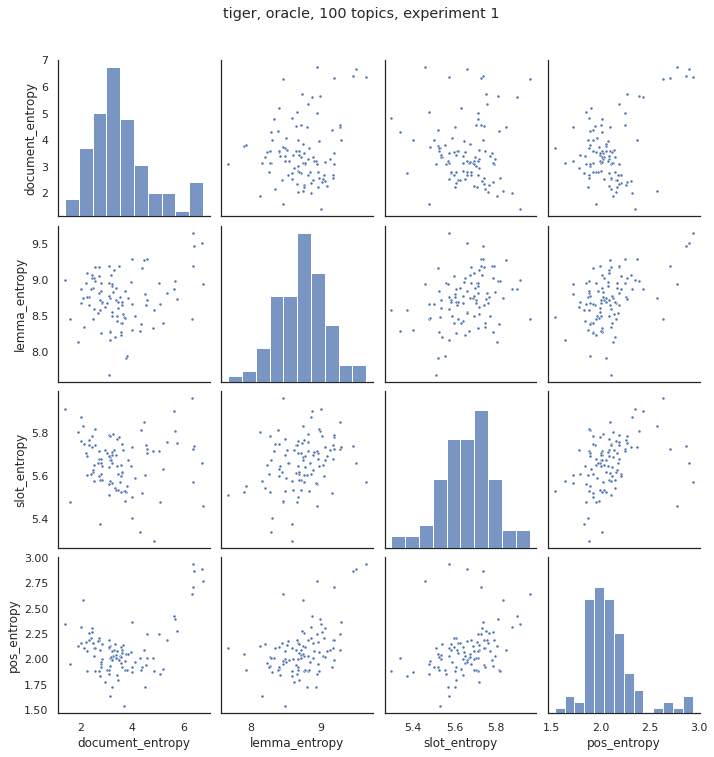

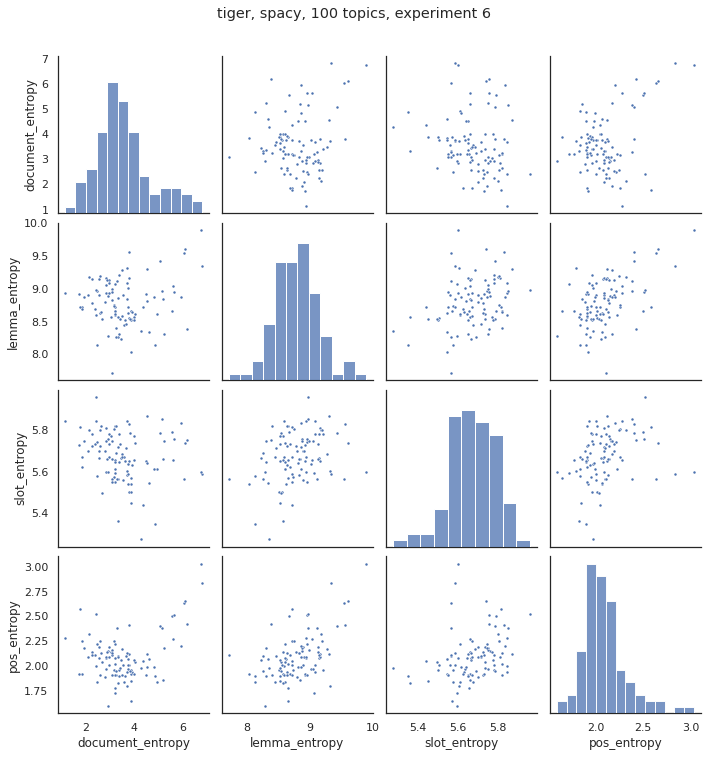

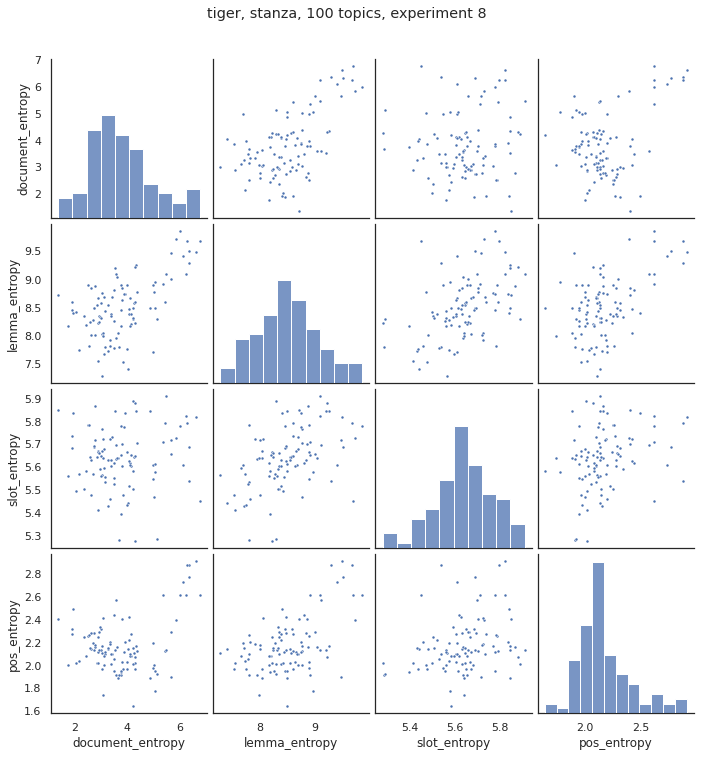

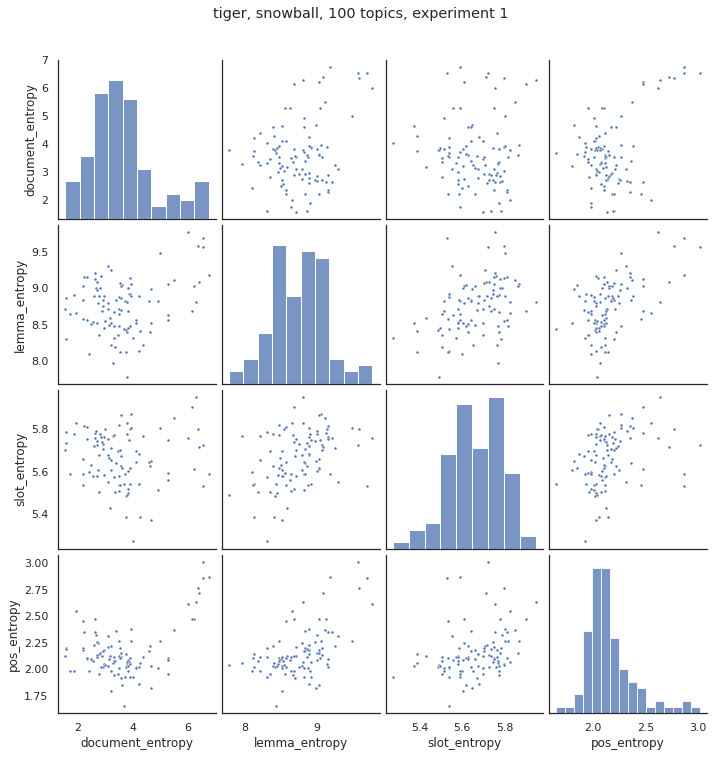

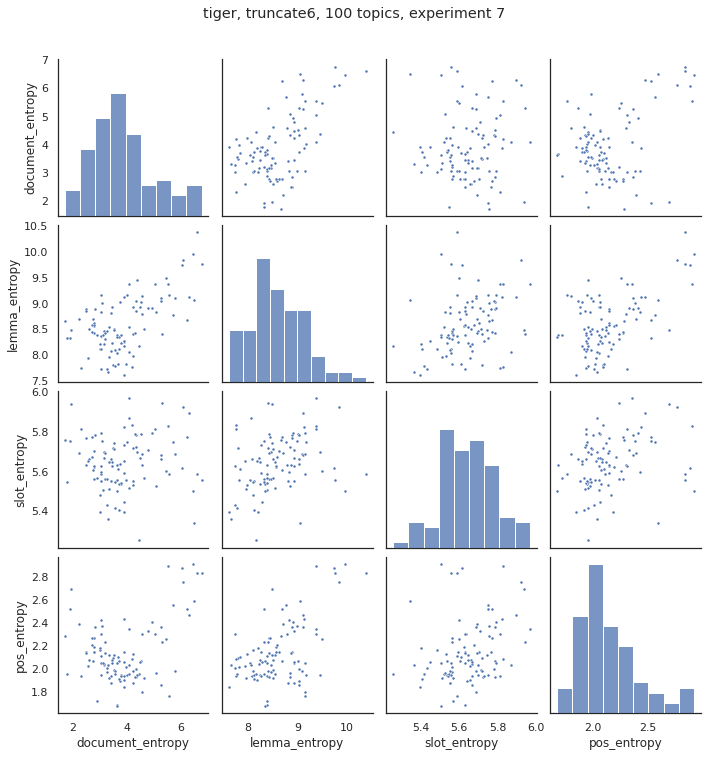

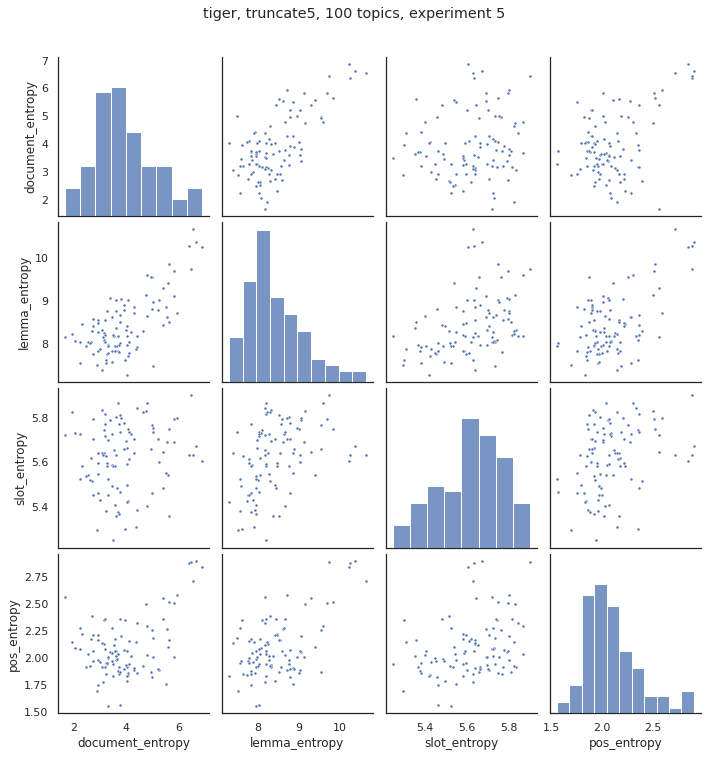

In [39]:
    # The same pair plots for a single experiment in each stemmer type
    counter = 0
    for i, pair in enumerate(num_topics_splits):
        num_topics, df = pair
        for treatment in hue_order:
            tmp_df = df[df['stemmer'] == treatment]
            experiment_id = random.randrange(10)
            tmp_df = tmp_df[tmp_df['experiment_id'] == str(experiment_id)]
            plt.figure(counter)
            g = sns.pairplot(tmp_df, vars=entropy_metrics, markers='.')
            g.fig.suptitle(f"{corpus_name}, {treatment}, {num_topics} topics, experiment {experiment_id}", y = 1.05)
            counter+=1

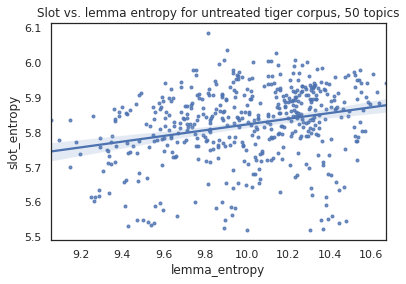

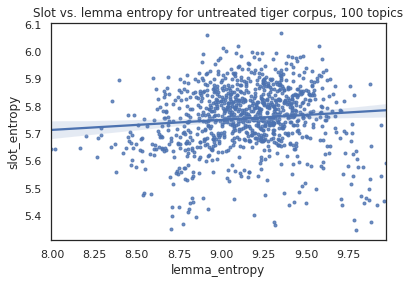

In [40]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['stemmer'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name} corpus, {num_topics} topics")

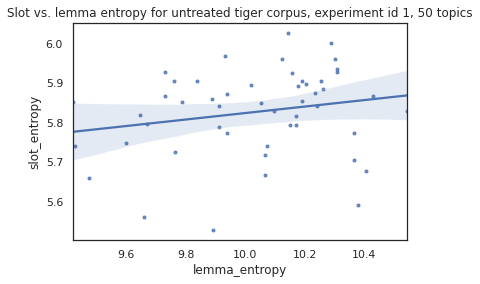

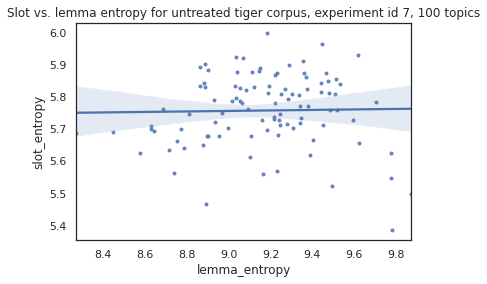

In [41]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['stemmer'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name} corpus, experiment id {experiment_id}, {num_topics} topics")

In [42]:
raw_df.sort_values(['lemma_entropy', 'slot_entropy'], inplace=True)
print("Topics with no treatment, sorted by ascending lemma entropy and slot entropy")
print("Head - low lemma entropy")
display(raw_df.head(5))
print("Tail - high lemma entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending lemma entropy and slot entropy
Head - low lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5607,4,57,100,7.994149,5.645071,aleksander danziger homo polnischen edith kuron polens polnische heller lech vermögenserklärung kwasniewski oecologicus sonntag walesa kwasniewskis warschau polen stichwahl walesas,pole aleksander danziger homo edith kuron heller lech vermögenserklärung kwasniewski oecologicus sonntag polnisch walesa kirche katholisch warschau ex-kommunist polen stichwahl,pole aleksander danziger homo edith kuron heller lech vermögenserklärung kwasniewski oecologicus sonntag polnisch walesa pol warschau polen stichwahl walesas,katholisch kirche ex-kommunist,19,3
5859,0,59,100,8.015891,5.645077,präsident polnische polen kwasniewski umfragen kwasniewskis walesas aleksander frau heller vermögenserklärung stichwahl kuron polnischen lech amtsinhaber warschau polens sonntag walesa,präsident katholisch polen aleksander frau pole heller polnisch vermögenserklärung stichwahl kuron lech hochrechnung amtsinhaber anhänger warschau walesa umfrage sonntag kwasniewski,walesas aleksander frau präsident vermögenserklärung pole polen walesa stichwahl kuron polnisch umfrage lech heller amtsinhaber sonntag warschau kwasniewski,anhänger hochrechnung katholisch,18,3
5355,5,5,100,8.162309,5.648362,walesa kuron sonntag polens warschau aleksander lech danziger präsident vermögenserklärung polen kandidaten kwasniewskis polnische stichwahl hochrechnungen walesas heller polnischen kwasniewski,walesa kuron sonntag ex-kommunist warschau aleksander lech danziger präsident vermögenserklärung edith polen kandidat pole stichwahl katholisch polnisch heller kwasniewski hochrechnung,walesa kuron stichwahl sonntag polen warschau lech pole aleksander walesas kandidat präsident polnisch heller danziger vermögenserklärung kwasniewski hochrechnung,katholisch ex-kommunist edith,18,3
4579,2,79,100,8.199245,5.691913,erreichte wähler sonntag walesas aleksander runde stichwahl kwasniewski heller polnischen polen stimmen polnische prozent walesa kwasniewskis warschau lech polens kandidaten,wähler sonntag hochrechnung polnisch pole aleksander runde stichwahl kwasniewski kandidat heller umfrage polen prozent walesa warschau katholisch stimme lech erreichen,wähler sonntag walesas pole polnisch aleksander runde stichwahl kwasniewski kandidat heller polen stimmen prozent walesa warschau stimme lech erreichen,katholisch hochrechnung umfrage,19,3
4512,2,12,100,8.266962,5.614935,präsidenten usa veto clintons clinton gingrich republikaner powell dollar präsident dienstag bill newt republikanern kongreß perot demokraten washington us-präsident republikanischen,dole usa haus veto clinton gingrich republikaner powell weiß dollar republikanisch präsident bill haushalt demokrat newt kongreß perot washington us-präsident,clinton demokrat gingrich republikaner powell newt usa dollar washington wahington präsident republikanisch us-präsident dienstag bill kongreß perot veto,dole haus haushalt weiß,18,4


Tail - high lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5267,8,17,100,9.922337,5.441368,stehen steht thema gilt rolle lassen arbeit politik politische trotz bleiben frage fast halten weg sogar fall menschen bleibt geben,stehen zeigen mensch liegen lassen arbeit politik stellen bleiben frage sehen fast halten alt problem gelten führen politisch fall geben,stehen thema mensch rolle lassen arbeit politik trotz fragen bleiben frage bleibe fast halten weg sogar gelten politisch fall geben,problem führen liegen sehen zeigen alt stellen,20,7
5481,1,31,100,9.944253,5.732403,reise szene manchmal gefühl draußen gruppe weiß herr westen plötzlich deutschen außen vergessen mal ddr führt vorbei bißchen letzte kamen,reise szene manchmal gefühl geraten draußen herr westen deutsch führen plötzlich kommen vergessen mal wissen ddr letzter kopf vorbei bißchen,reise szene manchmal gefühl draußen gruppe weiß herr westen deutsch führen reisen plötzlich kommen deutsche außen vergessen mal wissen ddr letzter vorbei weiße bißchen,geraten kopf,24,2
5336,8,86,100,9.944307,5.546207,weiß deutschen welt eher lassen bringen art hand junge leben mann sehen grund anfang sogar mal leute menschen läßt schließlich,stehen wissen scheinen spielen mensch lassen bringen art hand leben mann sehen finden mal frau leute müssen wort deutsch schließlich,wissen weiß welt mensch eher lassen bringen art jung hand junge leben mann sehen grund anfang sogar mal weiße leute deutsch deutsche schließlich,spielen stehen frau müssen scheinen wort finden,23,7
5385,5,35,100,9.963325,5.452669,lassen eher frage leute schließlich alten läßt leben letzten menschen fast schwer weiß geschichte weg steht art wissen mal sehen,lassen geben zeigen frage nehmen schließlich finden alt mensch leben bringen scheinen schwer weg wissen bleiben letzter mal stehen sehen,lassen eher frage leute schließlich fragen weiße alt mensch leben fast schwer weiß geschichte weg alte art wissen letzter mal stehen sehen,bringen finden scheinen bleiben geben zeigen nehmen,22,7
5907,3,7,100,9.971909,5.594694,europäischen stellen steht ziel sogar lassen weg probleme angesichts fest gilt hält könnten bleibt rolle führen stehen frage gesellschaft fragen,halten stellen ziel wichtig bleiben lassen bestehen weg interesse gelten problem können europäisch neu stark international führen stehen frage hoch,halten stellen ziel sogar bleiben lassen weg gelten angesichts fest problem können europäisch fahren rolle stelle führen stehen frage gesellschaft fragen,international wichtig bestehen neu stark interesse hoch,21,7


In [43]:
raw_df.sort_values(['slot_entropy', 'lemma_entropy'], ascending=[True, False], inplace=True)
print("Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy")
print("Head - low slot entropy")
display(raw_df.head(5))
print("Tail - high slot entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy
Head - low slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5012,6,12,100,9.794338,5.346751,mußte weg sogar fall hält anfang lassen schließlich bringen meisten bleibt fast mal grund läßt sicher obwohl sieht steht nehmen,geben hand weg fall bleiben sehen lassen schließlich wissen müssen halten bringen stehen fast grund stellen setzen können meister nehmen,weg sogar fall anfang bleiben sehen lassen schließlich müssen halten bringen meisten stehen fast mal grund sicher obwohl meister nehmen,geben stellen setzen hand wissen können,20,6
5638,4,88,100,8.702857,5.351412,kohl grünen bundestag union helmut koalition spd bundeskanzler gerhardt csu cdu klaus blüm wolfgang peter bonn kanzler fdp günter rexrodt,kohl bundestag union helmut koalition spd grüne bundeskanzler gerhardt csu cdu klaus blüm wolfgang abgeordneter bonn kanzler fdp günter rexrodt,kohl bundestag union grün helmut koalition spd grüne bundeskanzler gerhardt csu cdu klaus blüm wolfgang peter bonn kanzler fdp günter rexrodt,abgeordneter,21,1
5586,4,36,100,9.314223,5.366309,angaben freitag land regierung dienstag woche sonntag montag entscheidung seite erklärte rtr afp mittwoch abend dpa november ap präsident sprecher,freitag land regierung dienstag gespräch woche erklären vorsitzend montag seite angabe afp mittwoch abend dpa november ap präsident fordern ministerpräsident,freitag land erklärt regierung dienstag woche erklären sonntag montag entscheidung seite angabe rtr afp mittwoch abend dpa november ap präsident sprecher,fordern ministerpräsident vorsitzend gespräch,21,4
5802,0,2,100,8.774825,5.370878,scharpings antrag parteitag lafontaines lafontaine mannheim schröder sozialdemokraten parteichef rau stellvertretende wahl partei delegierten oskar scharping rudolf ministerpräsident gerhard spd,delegierter antrag vorsitzend parteitag lafontaine mannheim schröder parteichef rau stellvertretend sozialdemokrat wahl partei oskar scharping rudolf ministerpräsident gerhard donnerstag spd,delegierter antrag parteitag lafontaine mannheim schröder parteichef rau stellvertretend delegierte sozialdemokrat wahl partei oskar scharping rudolf ministerpräsident gerhard spd,donnerstag vorsitzend,19,2
5493,1,43,100,9.884009,5.375968,land menschen letzten weg schließlich liegt frage sehen sogar eher leute lassen bleibt fall schwer geben läßt fast steht arbeit,land zeigen stehen weg bringen frage finden nehmen sehen sogar lassen stellen grund bleiben wissen müssen geben letzter politisch halten,land stehen weg schließlich frage fragen mensch sehen sogar eher leute lassen bleiben fall schwer geben liegen letzter fast arbeit,zeigen grund finden wissen nehmen politisch müssen halten stellen bringen,20,10


Tail - high slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5466,1,16,100,9.010912,6.015165,regeln rosalie postkommunistischen völkermord erscheinungen kigali mukakamali ruanda tschechen antifa kommunismus hutu postkommunistisch m kommunistischen autonomen tutsi göttinger früheren autonome,rosalie früh erscheinung autonom völkermord bürgerlich kigali mukakamali ruanda antifa kommunismus hutu m postkommunistisch tscheche kommunistisch tutsi regel göttinger autonome,rosalie früh erscheinung autonom völkermord kigali mukakamali ruanda antifa kommunismus hutu postkommunistisch m tscheche kommunistisch tutsi regel göttinger autonome,bürgerlich,19,1
5880,0,80,100,9.096922,6.019555,münchen währungsfonds milliarden großbritannien land konferenz ländern weltbank liberalisierung welt staaten länder dollar iwf regierungschefs japan internationalen usa gipfel westlichen,international münchen staat währungsfonds wirtschaftsgipfel großbritannien osteuropa land konferenz regierungschef liberalisierung welt dollar iwf milliarde japan westlich kredit usa gipfel,international staat münchen währungsfonds großbritannien land konferenz regierungschef weltbank liberalisierung welt dollar iwf milliarde japan westlich währungsfond usa gipfel,wirtschaftsgipfel kredit osteuropa,19,3
5378,5,28,100,9.576184,6.022412,aguinaldo einheimischen vanuatu cork republik museum frum josé philippinische erde eichendorff manila santo rizal nackten philippinen nambas jon lubowice tanna,aguinaldo vanuatu lubowice cork nackt republik museum oberschlesien frum josé spanisch eichendorff manila santo rizal philippinen jon erde philippinisch tanna,namba aguinaldo vanuatu cork nackt republik museum einheimische frum josé erde eichendorff tanna manila santo rizal philippinen nambas einheimisch jon lubowice philippinisch,oberschlesien spanisch,22,2
4871,9,21,100,8.915605,6.059483,japan amerikanischen liberalisierung investoren währungsfonds internationalen land japanischen wto milliarden staaten japanische firmen usa tokio ausländische iwf abkommen dollar welt,japan regierung wirtschaftlich liberalisierung land firma ausländisch investor amerikanisch milliarde usa staat tokio japanisch international iwf abkommen dollar kredit welt,japan währungsfond liberalisierung währungsfonds land firma ausländisch wto investor amerikanisch milliarde usa staat tokio japanisch international iwf abkommen dollar welt,wirtschaftlich kredit regierung,20,3
5851,0,51,100,9.350381,6.069291,griechischen theologie sitten aristoteles eure studium beiträgt atmen pollock alten griechische schönen siqueiros bildern wissenschaften dinge kenntnis philosophie studien lateinischen,griechisch theologie aristoteles studium schön atmen pollock griechische siqueiros alt römisch dein wissenschaft bild wissen kenntnis philosophie sitte ding lateinische,siqueiro alte griechisch theologie aristoteles studium schön atmen pollock griechische siqueiros alt beitragen lateinisch dein wissenschaft bild studie wissenschaften kenntnis philosophie sitte ding lateinische,wissen römisch,24,2


# Metrics dealing with the top terms and top lemmas for a topic
This covers exclusivity, ratios of morphological features to terms, lemmas covered or excluded by top terms. 

Treatment reduces exclusivity of the word type used by the topic model. 
Word types being more exclusive than lemmas means there's at least one word type that is concentrated in a particular topic. 


The number of lemmas in the top 20 terms (and the ratio of lemmas to top 20 forms) shows how much conflation each treatment causes - in the topic's key terms. Truncation and Stanza cause the most. Surprisingly, snowball doesn't have as large an effect. 

<Figure size 432x288 with 0 Axes>

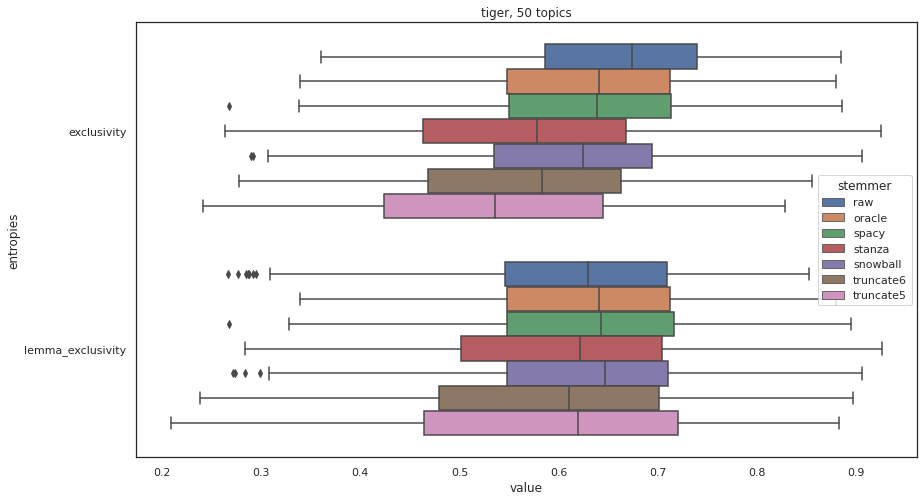

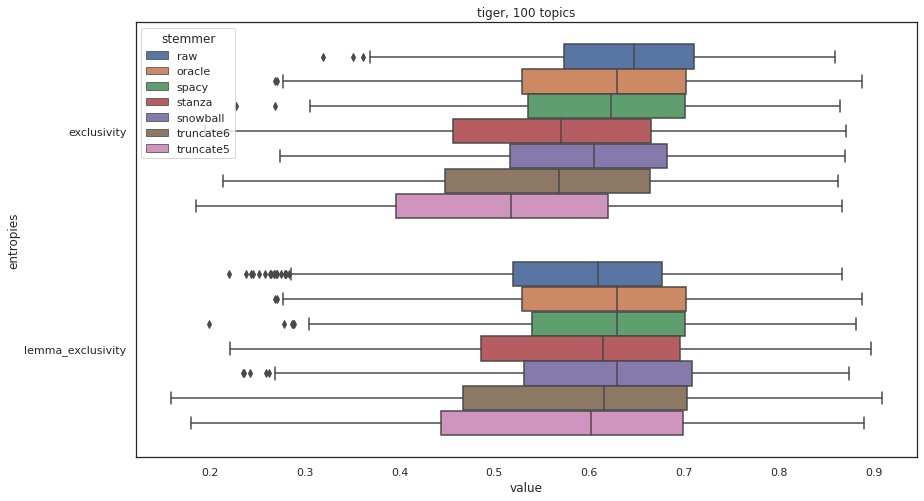

In [44]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    exclusivity_metrics = ['exclusivity', 'lemma_exclusivity']#, 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms']
    exclusivity_stats = pd.melt(df, "stemmer", var_name="entropies", value_vars=exclusivity_metrics)

    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="stemmer", data=exclusivity_stats, hue_order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

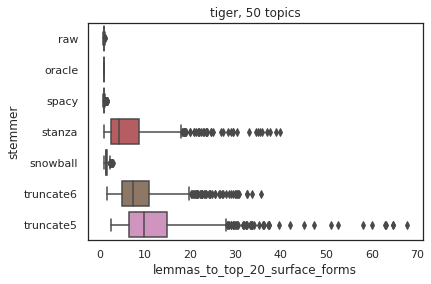

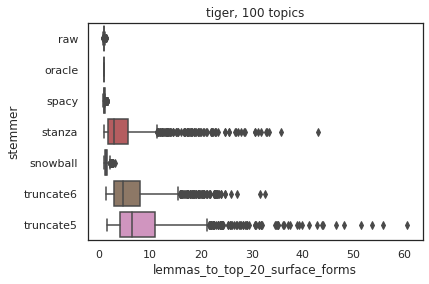

In [45]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemmas_to_top_20_surface_forms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

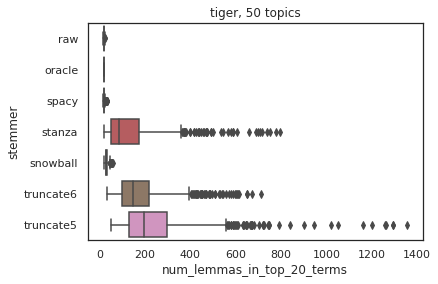

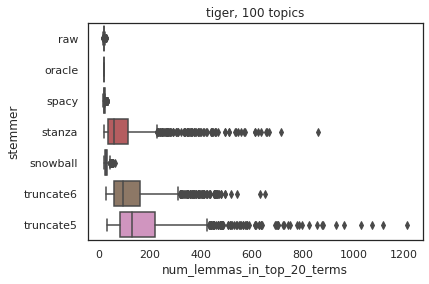

In [46]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_lemmas_in_top_20_terms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

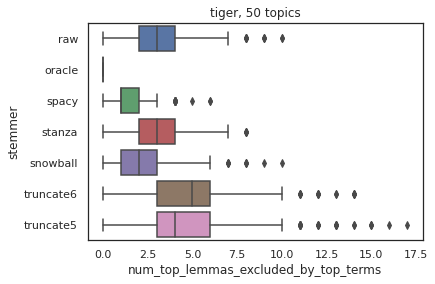

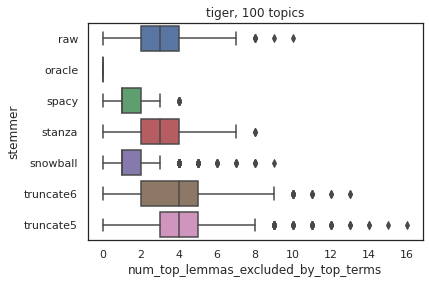

In [47]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_top_lemmas_excluded_by_top_terms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

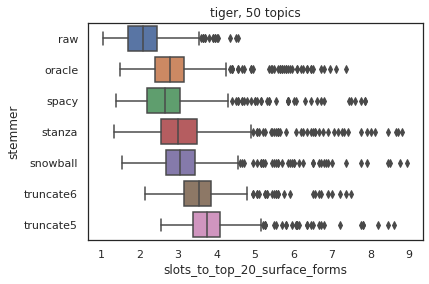

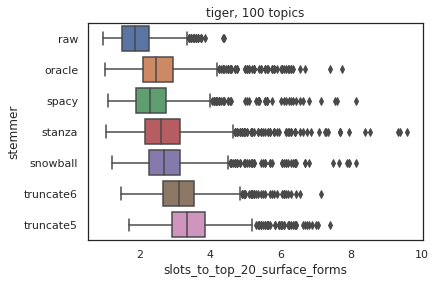

In [48]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slots_to_top_20_surface_forms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

In [49]:
# Sanity check - oracle exlusivity and oracle post-lemmatize exclusivity should be the same
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    oracle_df = df[df["stemmer"] == "oracle"]
    print("Num_topics:", num_topics)
    print("\tOracle exclusivity:", oracle_df['exclusivity'].mean())
    print("\tOracle lemma (post-lemmatize) exclusivity:", oracle_df['lemma_exclusivity'].mean())

Num_topics: 50
	Oracle exclusivity: 0.6294412
	Oracle lemma (post-lemmatize) exclusivity: 0.6294412
Num_topics: 100
	Oracle exclusivity: 0.6088726
	Oracle lemma (post-lemmatize) exclusivity: 0.6088726


# Variation of Information

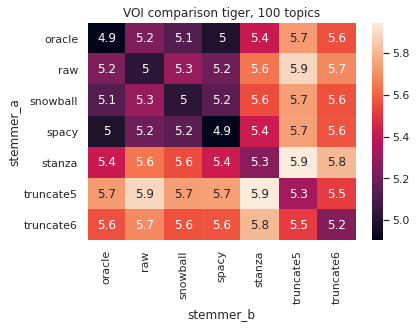

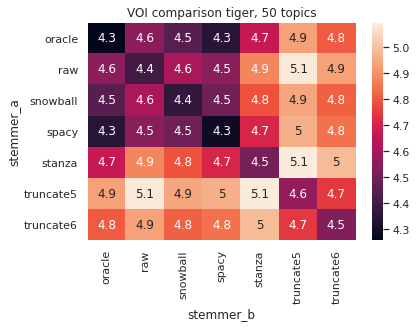

In [50]:
for i, voi in enumerate(voi_folders):
    num_topics = voi.name.split("_")[1]
    voi_frame = parse_voi_directory(voi)
    voi_means = voi_frame.groupby(["stemmer_a", "stemmer_b"], as_index=False)["voi"].mean()
    voi_means = voi_means.pivot(index="stemmer_a", columns="stemmer_b", values="voi")
    plt.figure(i)
    sns.heatmap(voi_means, annot=True).set_title(f"VOI comparison {corpus_name}, {num_topics} topics")


# General diagnostics
These are the standard diagnostics produced by Mallet

In [51]:
full_frame.columns

Index(['topic_id', 'corpus', 'stemmer', 'num_topics', 'experiment_id',
       'tokens', 'document_entropy', 'word-length', 'coherence',
       'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff',
       'rank_1_docs', 'allocation_ratio', 'allocation_count', 'exclusivity',
       'negative_coherence', 'lemma_exclusivity', 'lemma_entropy',
       'slot_entropy', 'pos_entropy', 'lemmas_to_top_20_surface_forms',
       'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms',
       'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms',
       'top_lemmas_minus_top_term_lemmas', 'top_term_lemmas_minus_top_lemmas',
       'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms',
       'num_top_term_lemmas_excluded_by_top_lemmas'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

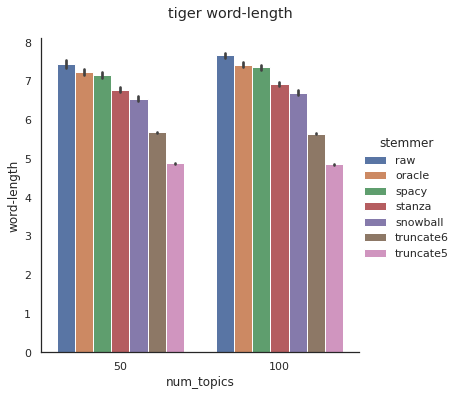

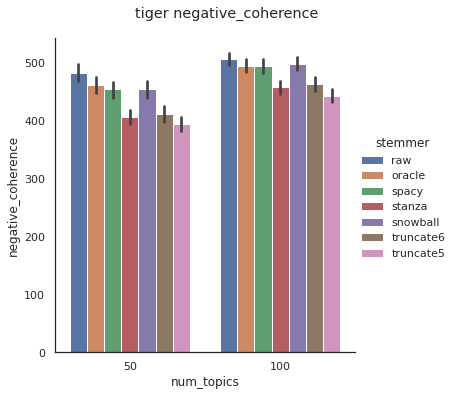

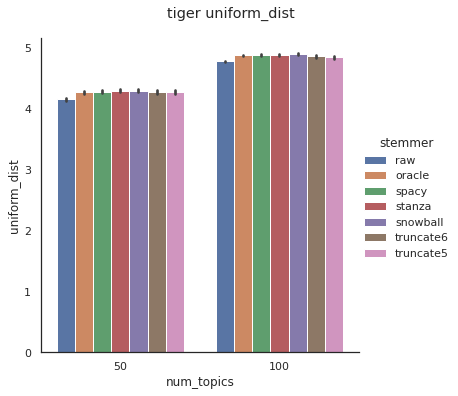

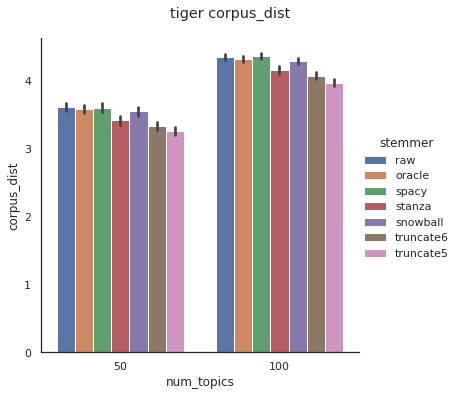

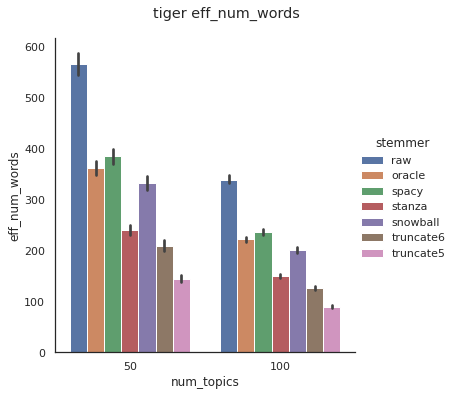

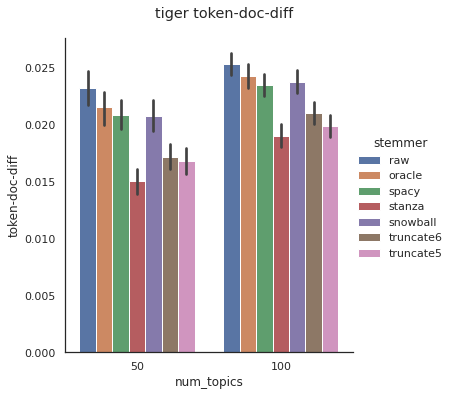

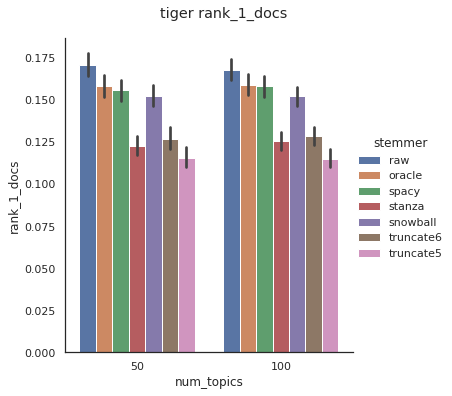

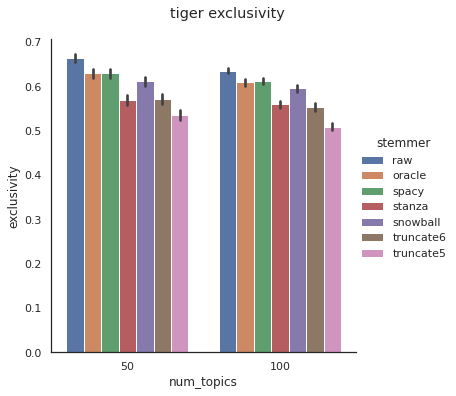

In [52]:
mallet_diagnostics = ['word-length', "negative_coherence", 'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff', 'rank_1_docs', 'exclusivity']
for i, m in enumerate(mallet_diagnostics):
    plt.figure(i)
    g = sns.catplot(data = full_frame, kind="bar", x="num_topics", y=m, hue="stemmer", hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name} {m}", y=1.05)
